# Exploring the hebrew poetry dataset

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
from poetry_processing import DATA_PATH
from prepare_data_set import COMBINED_DATA_PATH_PICKLE, TimePeriods
import matplotlib.pyplot as plt

In [4]:
from poetry_processing import get_only_words_and_digits, invert_words

def text_to_word_list(text: str):
    return get_only_words_and_digits(text)
    #return text.split()

### data to explore:
- [x] how many songs?
- [x] Total number of words and sentences, how many at each songs? mean? std?
- [x] the most common words?
- [x] bi-grams and tri-grams
- [x] wordcloud
- [x] songs/words/sentences by author? mean? std?
- [x] how many songs/words/sentences by men? how may by women?
- [x] authors timeline with all life spans.
- [x] songs/words/sentences by periods - death and birth
- [ ] translated songs: how many and compare translator to his other works
- [ ] songs/words/sentences by author place of birth or death
- [ ] songs/words/sentences by author in israel in birth or death

In [5]:
# load data
df = pd.read_pickle(COMBINED_DATA_PATH_PICKLE)
df['words_count'] = df.content.map(lambda x: len(text_to_word_list(x)))
authors_to_remove = df.loc[df.birth_period.isna()].author.unique()

# output path
OUTPUT_DIR_PATH = Path("eda_output")
if not OUTPUT_DIR_PATH.is_dir():
    OUTPUT_DIR_PATH.mkdir(parents=True)

### General statistics on the whole corpus

In [6]:
print(f"In our dataset there {df.shape[0]:,} poems, from {len(df.author.unique()):,} authors.\n"
      f"In total there {sum(df.words_count):,} words in all the poems, {df.words_count.mean():.3f} words in poem at average.\n"
      f"In our dataset there {df.shape[0]-sum(df.translators.isna()):,} translated poems with {sum(df.words_count.loc[np.logical_not(df.translators.isna())]):,} words \n"
      f"({sum(df.words_count.loc[np.logical_not(df.translators.isna())])/sum(df.words_count):.2%} of the dataset).\n"
      f"There {len(authors_to_remove):,} authors that we were unable to find out enough information about.\n"
      f"They are: ")
for author in authors_to_remove:
    print(f"\t{author} with {len(df.loc[df.author == author]):,} poems, that have {sum(df.loc[df.author == author].words_count):,} words.")
df_to_remove = df.loc[df.birth_period.isna()]
print(f"In total those authors have {df_to_remove.shape[0]:,} poems with {sum(df_to_remove.words_count):,} words\n"
      f"({float(sum(df_to_remove.words_count))/sum(df.words_count):.2%} of the dataset).")
df.dropna(subset=['birth_period', 'death_period'], inplace=True)
print(f"Because we can't use those authors we have to remove all their poems.\n"
      f"We left with {df.shape[0]:,} poems in our dataset, from {len(df.author.unique()):,} authors.\n"
      f"In total there {sum(df.words_count):,} words in all the poems, {df.words_count.mean():.3f} words in poem at average.\n"
      f"Also, we left with {df.shape[0]-sum(df.translators.isna()):,} translated poems with {sum(df.words_count.loc[np.logical_not(df.translators.isna())]):,} words \n"
      f"({sum(df.words_count.loc[np.logical_not(df.translators.isna())])/sum(df.words_count):.2%} of the dataset).\n")

In our dataset there 7,022 poems, from 162 authors.
In total there 1,754,486 words in all the poems, 249.856 words in poem at average.
In our dataset there 289 translated poems with 451,118 words 
(25.71% of the dataset).
There 3 authors that we were unable to find out enough information about.
They are: 
	אלמוני/ת with 30 poems, that have 30,057 words.
	חיא with 1 poems, that have 97 words.
	יצחק בעל “עזרת נשים” with 1 poems, that have 1,625 words.
In total those authors have 32 poems with 31,779 words
(1.81% of the dataset).
Because we can't use those authors we have to remove all their poems.
We left with 6,990 poems in our dataset, from 159 authors.
In total there 1,722,707 words in all the poems, 246.453 words in poem at average.
Also, we left with 259 translated poems with 421,061 words 
(24.44% of the dataset).



### Word cloud

<Figure size 432x288 with 0 Axes>

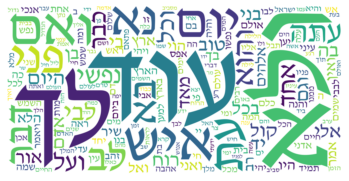

<Figure size 432x288 with 0 Axes>

In [6]:
from wordcloud import WordCloud
from heb_stop_words import STOP_WORDS # using spaCy hebrew stop words
WORD_CLOUD_FONT_PATH = Path("C:") / "WindowsFonts" / "david.ttf"

def create_word_cloud_from_corpus(poems: pd.Series, png_output: Path):
    stop_words = set(invert_words(STOP_WORDS))
    wordcloud = WordCloud(font_path=str(WORD_CLOUD_FONT_PATH), width=2000, height=1000, stopwords=stop_words,
                          background_color="white")
    wordcloud.generate(" ".join(text[::-1] for text in poems))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    wordcloud.to_file(png_output)
    return plt.figure()

create_word_cloud_from_corpus(df.content, OUTPUT_DIR_PATH / "corpus_word_cloud.png")

### Words and sentences

In [7]:
def most_common_words(texts: pd.Series, n: int, text_output_path: Path, stopwords: set = None):
    if stopwords is None:
	    stopwords = set()
    words_counter = Counter()
    for text in texts:
        for word in text_to_word_list(text):
            if word not in stopwords:
                words_counter[word] += 1
    sorted_word_count = sorted(words_counter.items(), key=lambda x:x[1], reverse=True)
    with open(text_output_path, 'w', encoding='utf-8') as f:
        for item in sorted_word_count:
            f.write(f"{item[0]} : {item[1]:,}\n")
    words, count = zip(*sorted_word_count[:n])
    words = invert_words(words)
    fig, ax = plt.subplots(figsize=(15,10))
    ax.bar(words, count)
    return ax

Text(0.5, 1.0, 'Most common words in all the data set')

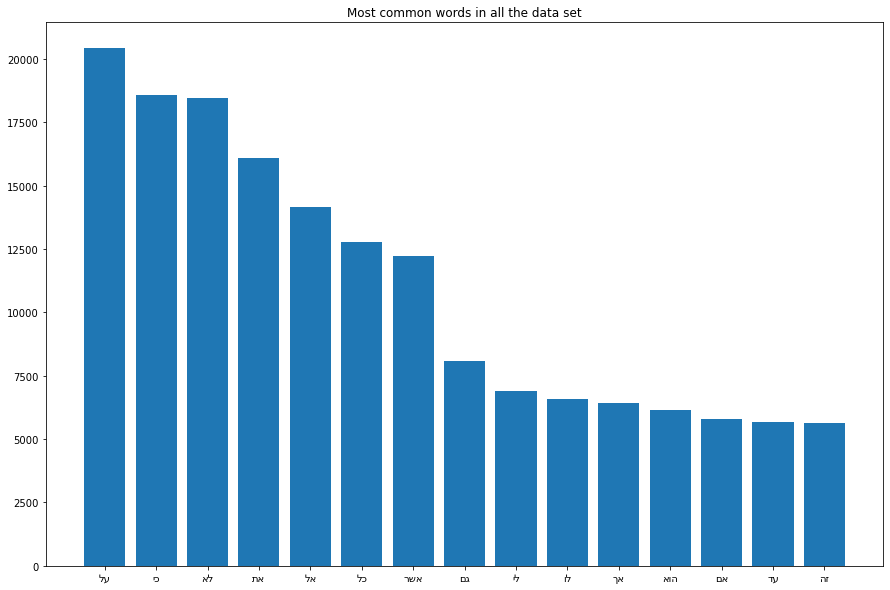

In [8]:
N = 15
ax = most_common_words(df.content, N, OUTPUT_DIR_PATH / "words_count_all_text.txt")
ax.set_title("Most common words in all the data set")

Text(0.5, 1.0, 'Most common words in all the data set without stopwords')

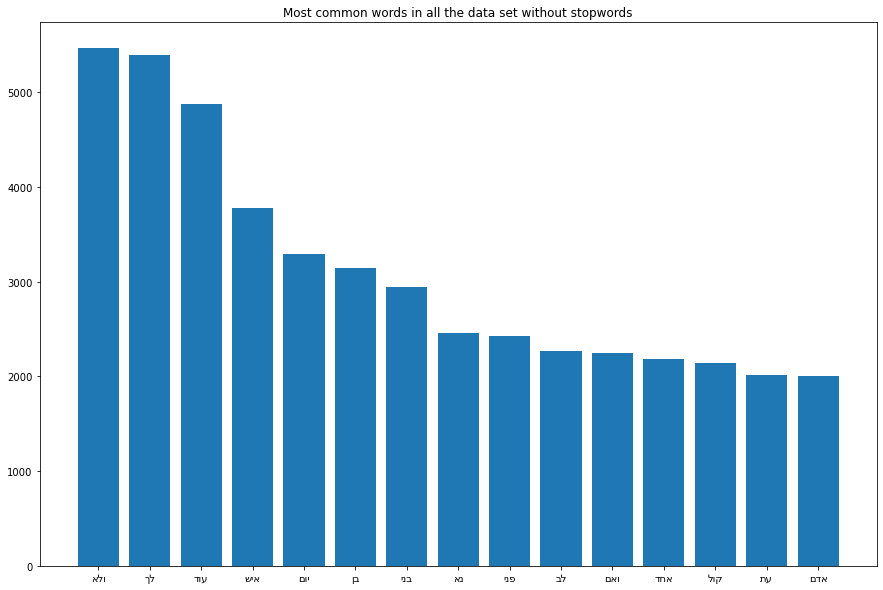

In [9]:
#from heb_stop_words import STOP_WORDS # using spaCy hebrew stop words
ax = most_common_words(df.content, N, OUTPUT_DIR_PATH / "words_count_all_text_wo_stopwords.txt", STOP_WORDS)
ax.set_title("Most common words in all the data set without stopwords")

In [10]:
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

def most_common_ngrams(texts: pd.Series, n: int=2, m: int=15, stopwords: set = None):
    if stopwords is None:
        stopwords = set()
    vec = CountVectorizer(ngram_range=(n, n)).fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                    for word, idx in vec.vocabulary_.items()]
    if stopwords:
        words_freq = [item for item in words_freq if all(w not in stopwords for w in item[0].split())]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)[:m]
    words, count = map(list,zip(*words_freq))
    return sns.barplot(x=count,y=invert_words(words))

Text(0.5, 1.0, 'top bi-grams')

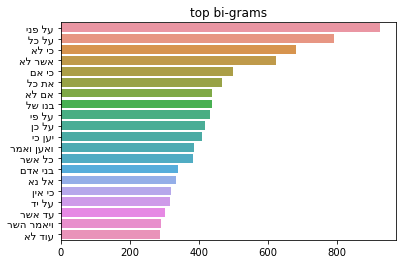

In [11]:
N = 20
most_common_ngrams(df.content, 2, N).set_title("top bi-grams")

Text(0.5, 1.0, 'top tri-grams')

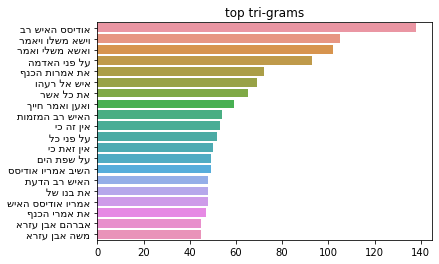

In [12]:
most_common_ngrams(df.content, 3, N).set_title("top tri-grams")

In [13]:
def plot_word_number_histogram(text: pd.Series):
    return text.map(lambda x: len(text_to_word_list(x))).hist(bins=50)

In total there 1,722,707 words in all the poems.
246.453 words in poem at average and std of 2051.899.
At most there 116,224 words - at song איליאדה by הומרוס


Text(0.5, 1.0, 'Histogram of words count')

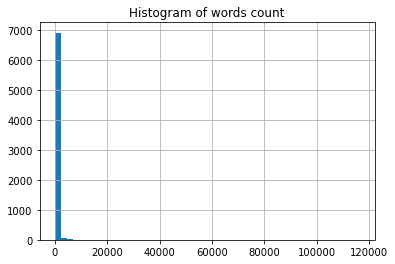

In [14]:
print(f"In total there {sum(df.words_count):,} words in all the poems.\n"
      f"{df.words_count.mean():.3f} words in poem at average and std of {df.words_count.std():.3f}.")
max_words = df.loc[df.words_count == df.words_count.max()]
print(f"At most there {df.words_count.max():,} words - at song {max_words.title.iat[0]} by {max_words.author.iat[0]}")
plot_word_number_histogram(df.content).set_title("Histogram of words count")
#df.to_csv(OUTPUT_DIR_PATH / "words_count.csv", columns=["ID","title","authors","genre","words_count"])

Not all poems can be divided into sentences, because there are some whose structure that doesn't use sentences.
That is why there 1,608 poems that we count them with only one sentence (23.00%).
Nevertheless, there 97,939 sentences in dataset (according to our basic sentences separator function).
14.011 sentences at average at poem and std of 115.416.
At most there 5,246 sentences - at poem איליאדה by הומרוס.


Text(0.5, 1.0, 'Histogram of sentences count')

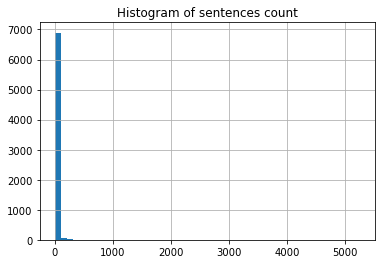

In [15]:
df["sentences_count"] = df.content_sep.map(len)
print(f"Not all poems can be divided into sentences, because there are some whose structure that doesn't use sentences.\n"
      f"That is why there {sum(df.sentences_count == 1):,} poems that we count them with only one sentence ({float(sum(df.sentences_count == 1))/df.shape[0]:.2%}).\n"
      f"Nevertheless, there {sum(df.sentences_count):,} sentences in dataset (according to our basic sentences separator function).\n"
      f"{df.sentences_count.mean():.3f} sentences at average at poem and std of {df.sentences_count.std():.3f}.")
max_sentences = df.loc[df.sentences_count == df.sentences_count.max()]
print(f"At most there {df.sentences_count.max():,} sentences - at poem {max_sentences.title.iat[0]} by {max_sentences.author.iat[0]}.")
df.sentences_count.hist(bins=50).set_title("Histogram of sentences count")

### Authors statistics

There 159 authors in our data set.
Each author wrote 43.962 poems at average, with std of 113.352.
Each author wrote 10,834.635 words at average, with std of 25,959.283.
The author with the most poems in our dataset is אברהם אבן עזרא with 668 poems that contain 80,577 words.
The author with the most words in our dataset is הומרוס with 210,617 words in 3 poems.



Text(0.5, 1.0, 'Histogram of authors poems count')

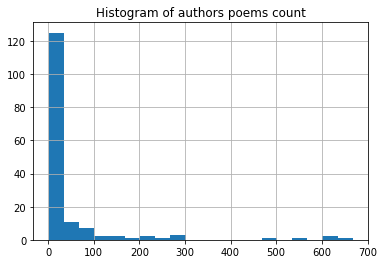

In [16]:
author_groups = df.groupby(['author'])
print(f"There {len(df.author.unique()):,} authors in our data set.\n"
      f"Each author wrote {df.author.value_counts().mean():,.3f} poems at average, with std of {df.author.value_counts().std():,.3f}.\n"
      f"Each author wrote {author_groups.words_count.sum().mean():,.3f} words at average, with std of {author_groups.words_count.sum().std():,.3f}.\n"
      f"The author with the most poems in our dataset is {df.author.value_counts().index[0]} with {df.author.value_counts()[0]:,} poems that contain {author_groups.get_group(df.author.value_counts().index[0]).words_count.sum():,} words.\n"
      f"The author with the most words in our dataset is {author_groups.words_count.sum().sort_values().index[-1]} with {author_groups.words_count.sum().max():,} words in {len(df.loc[df.author == author_groups.words_count.sum().sort_values().index[-1]]):,} poems.\n")
df.author.apply(lambda x: x[::-1]).value_counts().hist(bins=20).set_title("Histogram of authors poems count")

Text(0.5, 1.0, 'Histogram of authors words count')

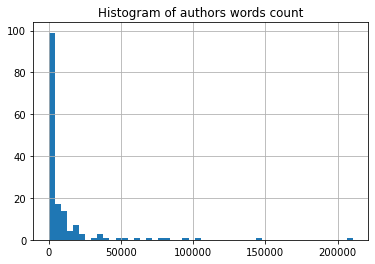

In [17]:
author_groups.words_count.sum().sort_values(ascending=False).hist(bins=50).set_title("Histogram of authors words count")

Text(0.5, 1.0, 'Authors with most poem count')

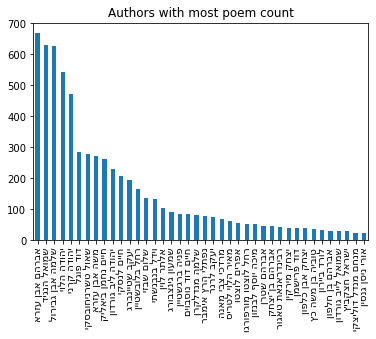

In [18]:
N = 40
authors_songs_count = df.author.value_counts()
with open(OUTPUT_DIR_PATH / "authors_songs_count.txt", 'w', encoding='utf-8') as file:
    for author, counts in authors_songs_count.iteritems():
        file.write(f"{author} : {counts}\n")
authors_songs_count[:N].rename(lambda x: x[::-1]).plot(kind='bar').set_title("Authors with most poem count")

Text(0.5, 1.0, 'Authors with most words count')

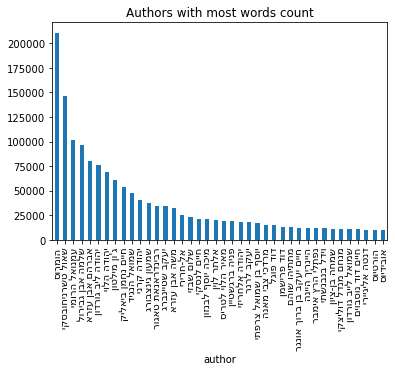

In [19]:
authors_words_count = author_groups.words_count.sum().sort_values(ascending=False)
with open(OUTPUT_DIR_PATH / "authors_words_count.txt", 'w', encoding='utf-8') as file:
    for author, counts in authors_words_count.items():
        file.write(f"{author} : {counts:,}\n")
authors_words_count[:N].rename(lambda x: x[::-1]).plot(kind='bar').set_title("Authors with most words count")

### Authors sex

Out of 159 there 152 males (95.60%) and 7 females (4.40%).
From our 6,990 poems, 6,666 created by a male authors (95.36%).
From 1,722,707 words in our dataset, 1,689,847 were wrote by male authors (98.09%) and 32,860 by female authors (1.91%).


Text(0.5, 1.0, "Poems author's sex")

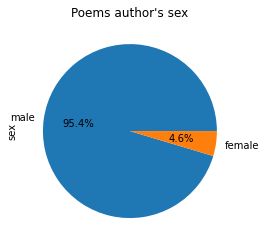

In [6]:
author_df = df.drop_duplicates(subset=["author"])
print(f"Out of {len(author_df):,} there {sum(author_df.sex == 'male'):,} males ({sum(author_df.sex == 'male')/len(author_df):.2%}) and {sum(author_df.sex == 'female'):,} females ({sum(author_df.sex == 'female')/len(author_df):.2%}).\n"
      f"From our {df.shape[0]:,} poems, {sum(df.sex == 'male'):,} created by a male authors ({sum(df.sex == 'male')/df.shape[0]:.2%}).\n"
      f"From {sum(df.words_count):,} words in our dataset, {df.loc[df.sex == 'male'].words_count.sum():,} were wrote by male authors ({df.loc[df.sex == 'male'].words_count.sum()/df.words_count.sum():.2%}) and {df.loc[df.sex == 'female'].words_count.sum():,} by female authors ({df.loc[df.sex == 'female'].words_count.sum()/df.words_count.sum():.2%}).")
df.sex.value_counts().plot.pie(autopct='%1.1f%%').set_title("Poems author's sex")

### Authors time periods

In [8]:
from prepare_data_set import TIME_PERIODS_RANGES
UNIX_EPOCH_YEAR = 1970

def date_to_year(date: np.datetime64):
    return np.datetime64(date, 'Y').astype('int') + UNIX_EPOCH_YEAR

def year_to_period(year: int):
    for period in TIME_PERIODS_RANGES:
        if int(year) in TIME_PERIODS_RANGES[period]:
            return period
    return TimePeriods.ancient

def plot_authors_time_periods(author_dataframe: pd.DataFrame, output_path: Path = None):
    author_dataframe = author_dataframe.sort_values(by=['born_year']).reset_index()
    fig, ax = plt.subplots(figsize=(15,5))
    for period in TIME_PERIODS_RANGES:
        current_df = author_dataframe.loc[author_dataframe.middle_life_period == period]
        ax.hlines(y=current_df.index, xmin=current_df.born_year, xmax=current_df.death_year, label=period.name, colors=f'C{period.value}')
    for time_period in TIME_PERIODS_RANGES:
        ax.vlines(x=TIME_PERIODS_RANGES[time_period][-1], ymin=0, ymax=author_dataframe.shape[0]+5, colors='g', alpha=0.6)
    ax.set_xticks(np.arange(-1000, 2400, step=100))
    ax.legend(loc='upper left', title="middle life period")
    ax.get_yaxis().set_visible(False)
    if output_path is not None:
        fig.savefig(output_path)
    return ax

df['born_year'] =  df.d_birth.apply(date_to_year)
df['death_year'] = df.d_death.apply(date_to_year)
df['middle_life_period'] = (df.born_year + ((df.death_year - df.born_year) / 2)).apply(year_to_period)
author_df = df.drop_duplicates(subset=["author"])

Text(0.5, 1.0, 'Authors life spans')

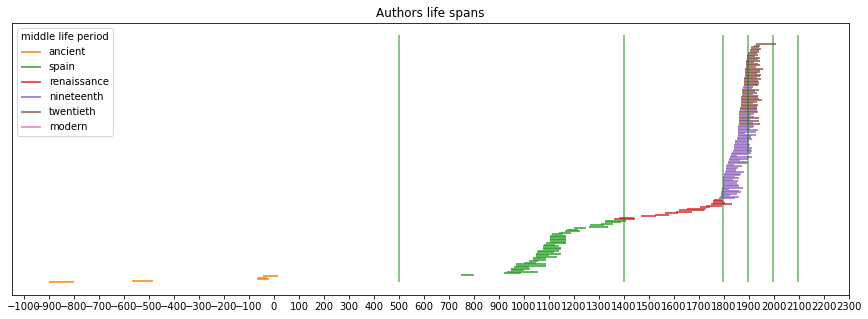

In [17]:
output_graph_path = OUTPUT_DIR_PATH / "authors_life_spans.png"
plot_authors_time_periods(author_df, output_graph_path).set_title("Authors life spans")

Text(0.5, 1.0, "Poems author's life spans")

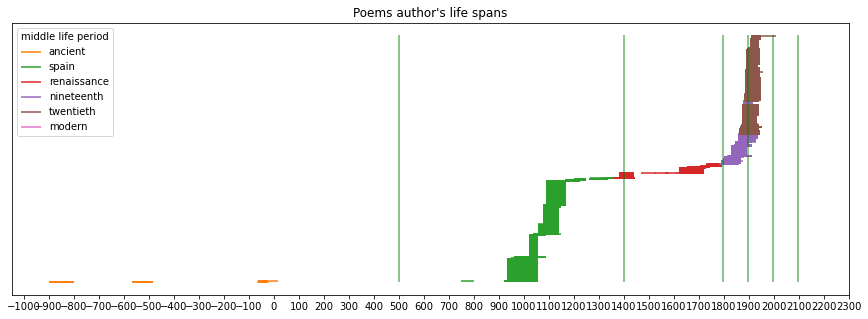

In [18]:
output_graph_path = OUTPUT_DIR_PATH / "songs_authors_life_spans.png"
plot_authors_time_periods(df, output_graph_path).set_title("Poems author's life spans")

array([<AxesSubplot:ylabel='author'>, <AxesSubplot:ylabel='poems'>,
       <AxesSubplot:ylabel='words'>], dtype=object)

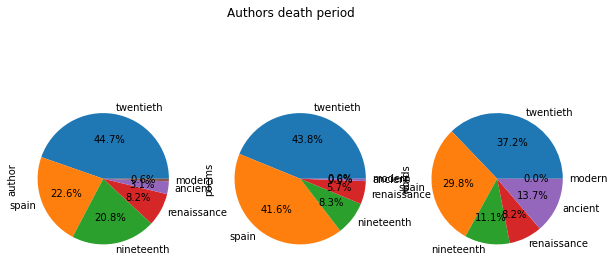

In [49]:
author_period_count = author_df.death_period.apply(lambda x: x.name).value_counts().to_frame(name="author")
songs_period_count = df.death_period.apply(lambda x: x.name).value_counts().to_frame(name="poems")
words_period_count = {}
for time_period in TimePeriods:
    words_period_count[time_period.name] = df.loc[df.death_period == time_period].words_count.sum()
words_period_count = pd.Series(words_period_count).to_frame(name="words")
pie_df = pd.concat([author_period_count, songs_period_count, words_period_count], axis=1).fillna(0)
pie_df.plot.pie(autopct='%1.1f%%', legend=False, subplots=True, figsize=(10, 5), title="Authors death period")

array([<AxesSubplot:ylabel='author'>, <AxesSubplot:ylabel='poems'>,
       <AxesSubplot:ylabel='words'>], dtype=object)

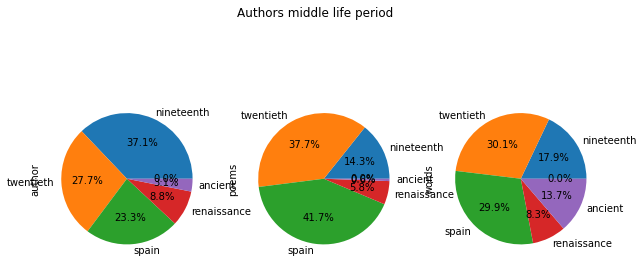

In [50]:
author_period_count = author_df.middle_life_period.apply(lambda x: x.name).value_counts().to_frame(name="author")
songs_period_count = df.middle_life_period.apply(lambda x: x.name).value_counts().to_frame(name="poems")
words_period_count = {}
for time_period in TimePeriods:
    words_period_count[time_period.name] = df.loc[df.middle_life_period == time_period].words_count.sum()
words_period_count = pd.Series(words_period_count).to_frame(name="words")
pie_df = pd.concat([author_period_count, songs_period_count, words_period_count], axis=1).fillna(0)
pie_df.plot.pie(autopct='%1.1f%%', legend=False, subplots=True, figsize=(10, 5), title="Authors middle life period")

array([<AxesSubplot:ylabel='author'>, <AxesSubplot:ylabel='poems'>,
       <AxesSubplot:ylabel='words'>], dtype=object)

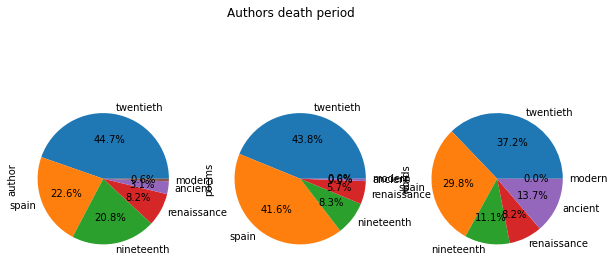

In [51]:
author_period_count = author_df.death_period.apply(lambda x: x.name).value_counts().to_frame(name="author")
songs_period_count = df.death_period.apply(lambda x: x.name).value_counts().to_frame(name="poems")
words_period_count = {}
for time_period in TimePeriods:
    words_period_count[time_period.name] = df.loc[df.death_period == time_period].words_count.sum()
words_period_count = pd.Series(words_period_count).to_frame(name="words")
pie_df = pd.concat([author_period_count, songs_period_count, words_period_count], axis=1).fillna(0)
pie_df.plot.pie(autopct='%1.1f%%', legend=False, subplots=True, figsize=(10, 5), title="Authors death period")

## Authors place

## test data on with twentieth_century songs

In [ ]:
#from sklearn.model_selection import train_test_split

#X = combined_df.content
#y = combined_df.d_renaissance

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## run the pipeline:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

vectorizer=CountVectorizer(ngram_range=(1,2))
transformer=TfidfTransformer(use_idf=False)
algo=RandomForestClassifier()

pipe = Pipeline([('vectorizer', vectorizer),
                 ('transformer', transformer),
                 #('feature_select', SelectKBest(chi2, k=20000)),
                 ('algo', algo)])

#pipe.fit(X_train, y_train)
#prediction = pipe.predict(X_test)
#plot_confusion_matrix(pipe, X_test, y_test)
#plt.show()

In [ ]:
# try XGBoost https://xgboost.readthedocs.io/en/latest/python/python_api.html


